In [1]:
from os import path
import time as t
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy.io import readsav

from tfcat import TFCat

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from mpl_toolkits import axes_grid1
from matplotlib.patches import Polygon


In [2]:
def comparison(date_start, date_end, LFE_data_directory, lfe_unet_data, lfe_joined_list):
    # define number of polygons in time range
    data_start = pd.Timestamp(date_start)
    data_end = pd.Timestamp(date_end)
    
    # Define Number of NOT JOINED LFEs - supposedly TOTAL
    full_df = pd.read_csv(lfe_unet_data)
    full_df = full_df.loc[(full_df['start'] >= date_start) & (full_df['start'] <= date_end)]
    saved_polys = get_polygons(polygon_fp, data_start, data_end)
    poly_num = len(saved_polys)
    print('Uncalibrated, total polygons:', poly_num)

    # define number of JOINED LFEs given in 'joined....csv' file 
    joint = pd.read_csv(lfe_joined_list)
    joint_min = joint.loc[(joint['start'] >= date_start) & (joint['start'] <= date_end)]
    joint_num = np.shape(joint_min)[0]
    print('Joined Polygons:', joint_num)

    '''
    if poly_num == joint_num:
        print('No polygons need joining!')
    else:
        print('We need to join some polygons!')
    '''
    
    return full_df, saved_polys, joint_min, poly_num, joint_num

In [3]:
def plot_flux2(ax,time_view_start, time_view_end, file, colour_in=None, frequency_lines=None,fontsize=18):
    
    #Load data from .sav file
    time, freq, flux = extract_data(file, time_view_start=time_view_start,\
                                    time_view_end=time_view_end,val='s')
    #Parameters for colorbar
    #This is the function that does flux normalisation based on s/c location
    #vmin, vmax=plt_func.flux_norm(time[0], time[-1])   #change from log10 to actual values.
    clrmap ='gist_gray' ## Changed from 'viridis'
    vmin = np.quantile(flux[flux > 0.], 0.05)
    vmax = np.quantile(flux[flux > 0.], 0.95)
    scaleZ = colors.LogNorm(vmin=vmin, vmax=vmax)
    
    #Make figure
    fig = plt.figure()
    im=ax.pcolormesh(time, freq, flux, norm=scaleZ,cmap=clrmap,  shading='auto')
    ax.set_yscale('log')
    ax.set_facecolor("#F4ECFF") ## Changed from NONE
    
    #format axis 
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    ax.set_ylabel('Frequency (kHz)', fontsize=fontsize)
    #ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_title(f'{time_view_start} to {time_view_end}', fontsize=fontsize + 2)
    
    ######### X label formatting ###############
    
    #For more concise formatting (for short time durations)
    #ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
    #normal
    dateFmt = mdates.DateFormatter('%m-%d\n%H:%M')
    ax.xaxis.set_major_formatter(dateFmt)
    
    #For using trajectory data
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(plt_func.ephemeris_fmt_hour_tick))
    #eph_str = '\n'.join(['DOY\n',
     #           r'$R_{sc}$ ($R_{S}$)',
      #          r'$\lambda_{sc}$ ($^{\circ}$)',
       #         r'LT$_{sc}$ (Hrs)'])
    #kwargs = {'xycoords': 'figure fraction',
     #   'fontsize': fontsize-6}
    #kwargs['xy'] = (0.03, 0.009)
    #ax.annotate(eph_str,**kwargs)
    
    # Formatting colourbar
    divider = axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.15, pad=0.2)
    cb = fig.colorbar(im, extend='both', shrink=0.9, cax=cax, ax=ax)
    cb.set_label(r'Flux Density'+'\n (W/m$^2$/Hz)', fontsize=fontsize-2)
    cb.ax.tick_params(labelsize=fontsize-2)
    #cb.remove()
    
    #For adding horizontal lines at specific frequencies
    if frequency_lines is not None:
        for i in frequency_lines:
            ax.hlines(i, time[0], time[-1], colors = 'darkslategray',linewidth=1,linestyles='--', label='{}kHz'.format(i))
          
     #For plotting polygons onto spectrogram.
    if colour_in is not None:
        for shape in colour_in:
            shape_=shape.copy()
            shape_[:,0]=[mdates.date2num(datetime.fromtimestamp(i)) for i in shape_[:,0]]
            ax.add_patch(Polygon(shape_, color='blue', linestyle='solid',linewidth=2, alpha=1, fill=False)) ## Changed from color = 'black', linestyle = 'dashed', linewidth = 2
        
    plt.close(fig)
    return ax

In [4]:
def get_polygons(polygon_fp,start, end):
    #print("are we getting here and finding polygons?")        
    unix_start=t.mktime(start.utctimetuple())
    unix_end=t.mktime(end.utctimetuple())
    #array of polygons found within time interval specified.
    polygon_array=[]
    if path.exists(polygon_fp):
        #print(" a path exists ")
        catalogue = TFCat.from_file(polygon_fp)
        #breakpoint()
        #print(" a catalogue exists ")
        #for i in range(len(catalogue)):
        for i in range(len(catalogue._data["features"])):
            time_points=np.array(catalogue._data["features"][i]['geometry']['coordinates'][0])[:,0]
            if any(time_points <= unix_end) and any(time_points >= unix_start):
                polygon_array.append(np.array(catalogue._data["features"][i]['geometry']['coordinates'][0]))
    
    return polygon_array

In [5]:
def extract_data(file_data, time_view_start, time_view_end, val):
    # read the save file and copy variables
    time_index = 't'
    freq_index = 'f'
    val_index = val
    file = readsav(file_data)

    t_doy = file[time_index].copy()
    doy_one = pd.Timestamp(str(1997)) - pd.Timedelta(1, 'D')
    t_timestamp = np.array([doy_one + pd.Timedelta(t * 1440, 'm') for t in t_doy],
        dtype=pd.Timestamp)
    t_isostring = np.array([datetime.strftime(i,'%Y-%m-%dT%H:%M:%S') for i in t_timestamp])
    time =t_isostring
    #print(time)
    #time = np.vectorize(fix_iso_format)(t_isostring)
    time = np.array(time, dtype=np.datetime64)
    time_view = time[(time >= time_view_start) & (time < time_view_end)]

    # copy the flux and frequency variable into temporary variable in
    # order to interpolate them in log scale
    s = file[val_index][:, (time >= time_view_start) & (time <= time_view_end)].copy()
    frequency_tmp = file[freq_index].copy()

    # frequency_tmp is in log scale from f[0]=3.9548001 to f[24] = 349.6542
    # and then in linear scale above so it's needed to transfrom the frequency
    # table in a full log table and einterpolate the flux table (s --> flux
    frequency = 10**(np.arange(np.log10(frequency_tmp[0]), np.log10(frequency_tmp[-1]), (np.log10(max(frequency_tmp))-np.log10(min(frequency_tmp)))/399, dtype=float))
    flux = np.zeros((frequency.size, len(time_view)), dtype=float)

    for i in range(len(time_view)):
        flux[:, i] = np.interp(frequency, frequency_tmp, s[:, i])

    return time_view, frequency, flux

In [6]:
def europe_dst_range(year):
    DST_start = datetime(year = 1, month = 3, day = 25, hour = 1, minute = 0)
    DST_end = datetime(year = 1, month = 10, day = 25, hour = 1, minute = 0)

    dst_start = find_last_sunday(DST_start.replace(year = year)) # Find explicit dates of DST for specific input year
    dst_end = find_last_sunday(DST_end.replace(year = year))

    return dst_start, dst_end # Defines datetime limits for .json file corrections per year (from 2004 to 2017 - the time period we have Cassini data for)

def find_last_sunday(date):
    days_left = 6 - date.weekday()
    # .weekday() - datetime.date class function that returns an integer value that corresponds to the day of the week
    # I.e. 0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, and 6 - Sunday
    if days_left != 0:
        date += timedelta(days = days_left) # Add number of days to obtain LAST SUNDAY of March & October
    return date 

In [7]:
data_start = pd.Timestamp('2004-02-21')
data_end = pd.Timestamp('2004-02-22')

polygon_fp = '../data/raw/2004001_2017258_catalogue.json'
lfe_detections_fp =  '../data/calculated/lfe_detections_unet.csv'
lfe_joined_fp = '../data/calculated/LFEs_joined.csv'

file = '../data/raw/SKR_raw/SKR_2004_CJ.sav'

Uncalibrated, total polygons: 2
Joined Polygons: 1
Data start (automatically calculated) is
2004-02-21 01:30:00
Data end (automatically calculated) is
2004-02-21 23:03:00
2 polygons are within: 2004-02-21 01:30:00 and  2004-02-21 23:03:00


/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_67528/2816952563.py:49: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(im, extend='both', shrink=0.9, cax=cax, ax=ax)
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_67528/2816952563.py:49: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 4 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(im, extend='both', shrink=0.9, cax=cax, ax=ax)


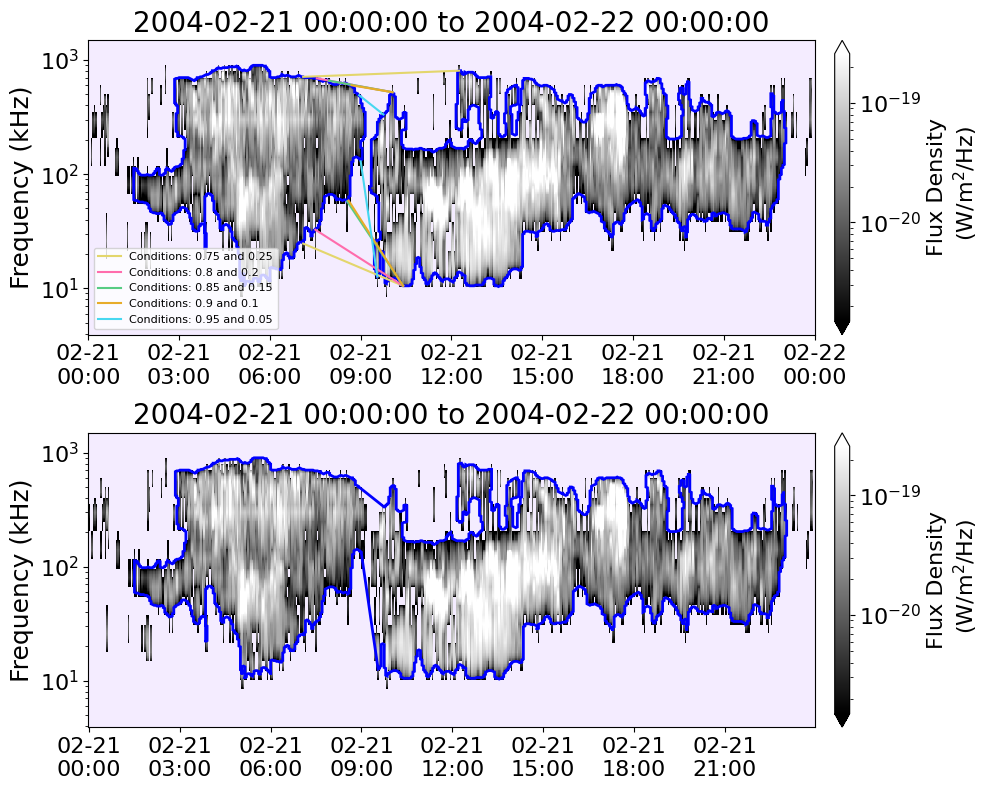

In [8]:
total_df, saved_polys, joint_polys, poly_num, joint_num = comparison(str(data_start), str(data_end), None, lfe_detections_fp, lfe_joined_fp)

if poly_num == joint_num:
    print('No polygons need joining within this time block!')
else:
    # We need to find EXACT START & END dates of original & joined polygons in a certain time interval
    # Want to find index values in TOTAL DF that 
    totalstart = np.unique(total_df['start'])
    totalend = np.unique(total_df['end'])
    jointstart = np.unique(joint_polys['start'])
    jointend = np.unique(joint_polys['end'])

    difstarts = []
    difends = []

    for element in totalend:
        if element not in jointend:
            difends.append(element)

    for element in totalstart:
        if element not in jointstart:
            difstarts.append(element)

    lo = []
    for i, j in zip(difends, difstarts):
        lo.append([i,j])

    # Save start & end times FOR FULL LFE DATA
    newstarts = []
    newends = []

    for l in range(len(lo)):
        place = np.where(total_df['end'] == difends[l])[0][0]
        newstarts.append(total_df['start'].iloc[place])
        newends.append(total_df['end'].iloc[place + 1])

    # Define quantiles / paths PER FIGURE
    quantiles0 = [0.75, 0.8, 0.85, 0.9, 0.95]
    quantiles1 = [0.25, 0.2, 0.15, 0.1, 0.05]
    
    # Take each polygon and join along 95% and 5% quantile lines
    for ind in range(len(newstarts)): # len(newstarts)
        # Initialize FIGURE
        num_panels=1
        fontsize=18
        fig_height = 8
        fig_width = 10

        plt.ioff()

        # Two panels - 1) Show 2 separate polygons with 5 different paths
                    #  2) Joint polygons !
        fig, (ax0, ax1) = plt.subplots(2, figsize=(fig_width, fig_height))
        #set width and height space between subplots
        fig.subplots_adjust(wspace=0.1,hspace=0.1)

        data_start_original=data_start
        data_end_original=data_end
        
        data_start = pd.Timestamp(f'{newstarts[ind]}') 
        data_end = pd.Timestamp(f'{newends[ind]}')
        
        print('Data start (automatically calculated) is')
        print(data_start)
        print('Data end (automatically calculated) is')
        print(data_end)
        
        #data_start=pd.Timestamp('2004-02-21')
        #data_end=pd.Timestamp('2004-02-22')
        
        
        print('2 polygons are within:', data_start, 'and ', data_end)

        saved_polys = get_polygons(polygon_fp, data_start, data_end)

        # ACCOUNTS FOR DAYLIGHT SAVING'S TIME - using european standards
        dst = True
        if dst == True:
            if data_start >= europe_dst_range(data_start.year)[0] and data_end <=  europe_dst_range(data_start.year)[1]:
                print('Subtracting an hour from these polygons:', data_start, ' and ', data_end)
                for i in range(len(saved_polys)):
                    for j in range(len(saved_polys[i])):
                        saved_polys[i][j, 0] = (datetime.fromtimestamp(saved_polys[i][j, 0]) - pd.Timedelta(1, 'hour')).timestamp()
            else:
                saved_polys = get_polygons(polygon_fp, data_start, data_end)
        else:
            pass 
    
        tup = []
        tlow = []
        fup = []
        flow = []
        conditions = []

        for quant0, quant1 in zip(quantiles0, quantiles1):
            #print('Quantiles:', quant0, quant1)
            # Polygon 0 - fmax, fmin, tmax
            max_t0 = max(saved_polys[0][:, 0])
            min_t0 = min(saved_polys[0][:, 0])
            cond = np.quantile(saved_polys[0][:, 0], quant0)

            # Find frequencies that pass threshold condition on POLYGON 0
            max_f0 = np.max(saved_polys[0][np.where(saved_polys[0][:, 0] >= cond), 1][0]) # Frequency MAX
            new_polys = saved_polys[0][np.where(saved_polys[0][:, 0] >= cond)] # BAD POINTS
            old_polys = saved_polys[0][np.where(saved_polys[0][:, 0] < cond)] # GOOD POINTS
            delete_polys_len0 = len(new_polys)
            ind_max_t = np.where(max_f0 == saved_polys[0][np.where(saved_polys[0][:, 0] >= cond),1])[1][0] # Index of time MAXIMUM from where to draw initial line
            max_t0_u = new_polys[ind_max_t, 0] # Actual T MAX Upper VALUE
            #print('Maximum t & Maximum freq for LEFT POLY:', max_t0_u, max_f0)

            min_f0 = np.min(saved_polys[0][np.where(saved_polys[0][:, 0] >= cond), 1][0]) # Frequency min
            ind_min_t = np.where(min_f0 == saved_polys[0][np.where(saved_polys[0][:, 0] >= cond),1])[1][0] # Index of time MINIMUM from where to draw initial line
            max_t0_l = new_polys[ind_min_t, 0] # Actual T MAX Lower VALUE
            #print('Maximum t & Minimum freq for LEFT POLY:', max_t0_l, min_f0)

            # Polygon 1 - fmax, fmin, tmin
            max_t1 = max(saved_polys[1][:, 0])
            min_t1 = min(saved_polys[1][:, 0])
            cond1 = np.quantile(saved_polys[1][:, 0], quant1)

            # Find frequencies that pass threshold condition on POLYGON 1
            max_f1 = np.max(saved_polys[1][np.where(saved_polys[1][:, 0] <= cond1), 1][0]) # Frequency MAX
            new_polys_1 = saved_polys[1][np.where(saved_polys[1][:, 0] <= cond1)] # BAD POINTS
            old_polys_1 = saved_polys[1][np.where(saved_polys[1][:, 0] > cond1)] # GOOD POINTS
            delete_polys_len1 = len(new_polys_1)
            ind_max_t1 = np.where(max_f1 == saved_polys[1][np.where(saved_polys[1][:, 0] <= cond1),1])[1][0]  # Index of time MAXIMUM from where to draw initial line
            min_t1_u = new_polys_1[ind_max_t1, 0]  # Actual T MIN upper VALUE
            #print('Minimum t & Maximum freq for RIGHT POLY:', min_t1_u, max_f1)

            min_f1 = np.min(saved_polys[1][np.where(saved_polys[1][:, 0] <= cond1), 1][0]) # Frequency min
            ind_min_t1 = np.where(min_f1 == saved_polys[1][np.where(saved_polys[1][:, 0] <= cond1),1])[1][0] # Index of time MINIMUM from where to draw initial line
            min_t1_l = new_polys_1[ind_min_t1, 0]  # Actual T MIN Lower VALUE
            #print('Minimum t & Minimum freq for RIGHT POLY:', min_t1_l, min_f1)

            # Apped to appropriate list
            tup.append([max_t0_u, min_t1_u])
            tlow.append([max_t0_l, min_t1_l])
            fup.append([max_f0, max_f1])
            flow.append([min_f0, min_f1])
            conditions.append([cond, cond1])

        #print('tup:', tup)
        #print('poly0 bad points:', new_polys)
        #print('poly1 bad points:', new_polys_1)
        #print('lengths:', delete_polys_len0, delete_polys_len1)

        # FIRST PLOT - separate polygons with QUANTILE LINES
    #    ax0=plot_flux2(ax0, data_start, data_end, file, colour_in=saved_polys, fontsize=fontsize)
        ax0=plot_flux2(ax0, data_start_original, data_end_original, file, colour_in=saved_polys, fontsize=fontsize)

        
        #colors_labels = ['red', 'orange', 'yellow', 'green', 'purple']
        colors_labels = ["#e3d66c",
"#ff6cac",
"#57cc83",
"#e7ac2a",
"#47d7f0"] 
        for i in range(len(tup)):
            #ax0.axvline(x = datetime.fromtimestamp(conditions[i][0]), linestyle = "--")
            #ax0.axvline(x = datetime.fromtimestamp(conditions[i][1]), linestyle = "--")
            # Generate NEW DATAPOINTS == len(new_polys)
            x10 = np.asarray(tup[i])
            y1 = np.asarray(fup[i])
            x1 = np.array([datetime.fromtimestamp(tup[i][0]), datetime.fromtimestamp(tup[i][1])])

            x20 = np.asarray(tlow[i])
            y2 = np.asarray(flow[i])
            x2 = np.array([datetime.fromtimestamp(tlow[i][0]), datetime.fromtimestamp(tlow[i][1])])
            
            # Define line parameters
            m1 = (y1[1]-y1[0]) / (x10[1]-x10[0])
            b1 = (y1 - (m1*x10))[0]
            m2 = (y2[1]-y2[0]) / (x20[1]-x20[0])
            b2 = (y2 - (m2*x20))[0]

            xnew10 = np.linspace(x10[0], x10[-1], delete_polys_len0) #delete_polys_len0
            ynew1 = m1*xnew10 + b1
            xnew1 = [datetime.fromtimestamp(xnew10[ind]) for ind in range(len(xnew10))]
            xnew20 = np.linspace(x20[0], x20[-1], delete_polys_len1) #delete_polys_len1
            ynew2 = m2*xnew20 + b2
            xnew2 = [datetime.fromtimestamp(xnew20[ind]) for ind in range(len(xnew20))]
            
            # PLOT
            ax0.plot([datetime.fromtimestamp(tup[i][0]), datetime.fromtimestamp(tup[i][1])], [fup[i][0], fup[i][1]], colors_labels[i], label = f"Conditions: {quantiles0[i]} and {quantiles1[i]}")
            ax0.plot([datetime.fromtimestamp(tlow[i][0]), datetime.fromtimestamp(tlow[i][1])], [flow[i][0], flow[i][1]], colors_labels[i])
            #ax0.scatter(xnew1, ynew1, s= 20, c= 'r')
            #ax0.scatter(xnew2, ynew2, s= 20, c= 'r')

        # Replace masked values with those along connecting lines - only for 95% & 5% which is last
        new_lists_1 = []
        new_lists_2 = []

        for x, y in zip(xnew10, ynew1):
            new_lists_1.append([x, y])

        new_lists_1 = np.asarray(new_lists_1)
        new_lists_1[:, 0] = [mdates.date2num(datetime.fromtimestamp(i)) for i in new_lists_1[:,0]]

        for x, y in zip(xnew20, ynew2):
            new_lists_2.append([x,y])

        new_lists_2 = np.asarray(new_lists_2)
        new_lists_2[:, 0] = [mdates.date2num(datetime.fromtimestamp(i)) for i in new_lists_2[:,0]]

        #ax0.set_xlim([datetime.fromtimestamp(tup[0][0]), datetime.fromtimestamp(tlow[0][1])])
        ax0.legend(loc = 'lower left', prop={'size': 8})
        #ax0.set_xlim([mdates.date2num(pd.Timestamp(newstarts[ind])), mdates.date2num(pd.Timestamp(newends[ind]))])
        ax0.set_xlim([mdates.date2num(pd.Timestamp(data_start_original)), mdates.date2num(pd.Timestamp(data_end_original))])
        # REDefine quantiles / paths PER FIGURE
        quantiles00 = np.array([0.75, 0.8, 0.85, 0.9, 0.95])

        ## AXIS 1 - JOINT POLYGONS
        # START W/ LIST 2
        # TIME BOUNDS
        # Pick b/w dif quantile
        perc_poly0 = 0.95
        q = np.where(quantiles00 == perc_poly0)[0][0]

        # Mask values b/w 95% initialization points 
        poly0_low_bound = np.where((saved_polys[0][:, 0] == tlow[q][0]) & (saved_polys[0][:, 1] == flow[q][0]))[0][0]
        poly0_up_bound = np.where((saved_polys[0][:, 0] == tup[q][0]) & (saved_polys[0][:, 1] == fup[q][0]))[0][0]
        mask0_ind = np.arange(poly0_low_bound+1, poly0_up_bound, 1)

        # Create a mask for certain points
        mask0 = np.zeros(np.shape(saved_polys[0])[0], dtype = bool)
        mask0[mask0_ind] = True
        masked_polys0 = saved_polys[0][~mask0]

        # Mask values b/w 5% initialization points 
        poly1_low_bound = np.where((saved_polys[1][:, 0] == tlow[q][1]) & (saved_polys[1][:, 1] == flow[q][1]))[0][0]
        poly1_up_bound = np.where((saved_polys[1][:, 0] == tup[q][1]) & (saved_polys[1][:, 1] == fup[q][1]))[0][0]
        mask1_ind = np.arange(poly1_up_bound+1, poly1_low_bound, 1)

        # Create a mask for certain points
        mask1 = np.zeros(np.shape(saved_polys[1])[0], dtype = bool)
        mask1[mask1_ind] = True
        masked_polys1 = saved_polys[1][~mask1]

        # Attach poly1_low to poly0_low
        ind_poly0_low = np.where((masked_polys0[:, 0] == tlow[q][0]) & (masked_polys0[:, 1] == flow[q][0]))[0][0]
        ind_poly0_up = np.where((masked_polys0[:, 0] == tup[q][0]) & (masked_polys0[:, 1] == fup[q][0]))[0][0]

        ind_poly1_low = np.where((masked_polys1[:, 0] == tlow[q][1]) & (masked_polys1[:, 1] == flow[q][1]))[0][0]
        ind_poly1_up = np.where((masked_polys1[:, 0] == tup[q][1]) & (masked_polys1[:, 1] == fup[q][1]))[0][0]

        # Reorder poly1 so that index 1 is at lowest bound
        masked_polys1 = np.concatenate([masked_polys1[ind_poly1_low:], masked_polys1[:ind_poly1_low]])
        lol = np.insert(masked_polys0, ind_poly0_low+1, masked_polys1, axis = 0)
        lol = [lol]
        
        # PLOT
        #ax1 = plot_flux2(ax1, data_start, data_end, file, colour_in = lol, fontsize=fontsize)
        ax1 = plot_flux2(ax1, data_start_original, data_end_original, file, colour_in = lol, fontsize=fontsize)

        # Print plots
        fig.tight_layout()
        plt.show()